# Using Reddit's API for Predicting Comments

In this project, we will practice two major skills. Collecting data via an API request and then building a binary predictor.

As we discussed in week 2, and earlier today, there are two components to starting a data science problem: the problem statement, and acquiring the data.

For this article, your problem statement will be: _What characteristics of a post on Reddit contribute most to the overall interaction (as measured by number of comments)?_

Your method for acquiring the data will be scraping the 'hot' threads as listed on the [Reddit homepage](https://www.reddit.com/). You'll acquire _AT LEAST FOUR_ pieces of information about each thread:
1. The title of the thread
2. The subreddit that the thread corresponds to
3. The length of time it has been up on Reddit
4. The number of comments on the thread

Once you've got the data, you will build a classification model that, using Natural Language Processing and any other relevant features, predicts whether or not a given Reddit post will have above or below the _median_ number of comments.

**BONUS PROBLEMS**
1. If creating a logistic regression, GridSearch Ridge and Lasso for this model and report the best hyperparameter values.
1. Scrape the actual text of the threads using Selenium (you'll learn about this in Webscraping II).
2. Write the actual article that you're pitching and turn it into a blog post that you host on your personal website.

### Scraping Thread Info from Reddit.com

#### Set up a request (using requests) to the URL below. 

*NOTE*: Reddit will throw a [429 error](https://httpstatuses.com/429) when using the following code:
```python
res = requests.get(URL)
```

This is because Reddit has throttled python's default user agent. You'll need to set a custom `User-agent` to get your request to work.
```python
res = requests.get(URL, headers={'User-agent': 'YOUR NAME Bot 0.1'})
```

In [28]:
# Imports for working with the reddit API
import requests
import json
import time

# Basic data science imports
import pickle
import pandas as pd
import numpy as np
import re

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling imports
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import svm, linear_model
from sklearn.linear_model import LogisticRegression

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Since reddit has blocked the default python user agent, it is necessary
# to define a new one to be allowed access to the API.
url = "http://www.reddit.com/hot.json"
headers = {'User-agent': 'Project 3 scraper'}
res = requests.get(url, headers=headers)
res.status_code

200

In [3]:
# Given that there are 25 posts per page, we know that we would need to make
# 400 requests to obtain 10,000 posts
jason = res.json()
len(jason['data']['children'])

25

#### Getting more results

By default, Reddit will give you the top 25 posts:

```python
print(len(data['data']['children']))
```

If you want more, you'll need to do two things:
1. Get the name of the last post: `data['data']['after']`
2. Use that name to hit the following url: `http://www.reddit.com/hot.json?after=THE_AFTER_FROM_STEP_1`
3. Create a loop to repeat steps 1 and 2 until you have a sufficient number of posts. 

*NOTE*: Reddit will limit the number of requests per second you're allowed to make. When you create your loop, be sure to add the following after each iteration.

```python
time.sleep(3) # sleeps 3 seconds before continuing```

This will throttle your loop and keep you within Reddit's guidelines. You'll need to import the `time` library for this to work!

In [39]:
# We will collate 10,000 posts from the reddit API with this script. First we
# initialize the list that will hold our data. Then we configure the script to
# iteratively append JSON data to our list over 400 pages of posts. Before
# each page, it will wait one second to abide by reddit's API guidelies.

posts = []
after = None
for i in range(400):
    if i % 50 == 0: # to print which iteration it is on every 50 pages
        print(i)
    if after == None:
        params = {}
    else:
        params = {'after': after} # stores information for going to next page after first loop
    url = 'https://www.reddit.com/hot.json'
    res = requests.get(url, params=params, headers=headers)
    if res.status_code == 200: # ensures that all is well before proceeding further
        jason = res.json() # gets JSON
        posts.extend(jason['data']['children']) # appends it to list
        after = jason['data']['after'] # points to next page for the res function next loop
    else:
        print(res.status_code) # will tell you what went wrong in case of failure
        break
    time.sleep(1) # minimum amount of wait time in accordance with reddit API guidelines

0
50
100
150
200
250
300
350


In [40]:
# We see that the full 10,000 were not retreived, though it is not entirely
# relevant as many of the posts are duplicates as it is
len(posts)

9987

In [147]:
# Pickling preserves data, allowing it to be transfered across environments

# Store the JSON list with most efficient pickle protocol
with open('./data/posts_6-3-18.pickle', 'wb') as handle:
    pickle.dump(posts, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Unpickle and reassign data to a placeholder variable to verify integrity
with open('./data/posts_6-3-18.pickle', 'rb') as handle:
    unserialized_data = pickle.load(handle)

# Verify integrity
print(posts == unserialized_data)

True


In [ ]:
# If all went well, deallocate the memory from the placeholder
del(unserialized_data)

## (Optional) Collect more information

While we only require you to collect four features, there may be other info that you can find on the results page that might be useful. Feel free to write more functions so that you have more interesting and useful data.

In [157]:
# A list of attributes that could be interesting to examine
attrs = [
    'title', 'score', 'num_comments', 'subreddit', 'subreddit_subscribers',
    'num_crossposts', 'created_utc', 'author', 'over_18', 'edited', 'gilded',
    'spoiler', 'id'
]

# A dictionary is the natural choice of data structure as it parallels JSON's
# dictionary like structure perfectly. Furthermore, it can be converted to a
# dataframe without any zip or fuss.
data_dict = {key:[] for key in attrs}

# This loop prunes the JSON down to just the necessary parts for our analysis
for n in range(len(posts)):
    for attribute in attrs:
        data_dict[attribute].append(posts[n]['data'][attribute])

In [158]:
# A deep thank you to Alex Lin for providing his automated scrapes. We will
# use four additional scrapes of 2,500 posts each to supplement our data.
with open('./data/2018_05_26__12_03_28.json') as jason:
    scrape1 = json.load(jason)
with open('./data/2018_05_27__12_03_30.json') as jason:
    scrape2 = json.load(jason)
with open('./data/2018_05_28__12_03_28.json') as jason:
    scrape3 = json.load(jason)
with open('./data/2018_05_29__12_03_32.json') as jason:
    scrape4 = json.load(jason)
    
scrapes = [scrape1, scrape2, scrape3, scrape4]

In [159]:
# The dictionary structure of Alex's scrapes are different than the JSON from
# earlier. As such, the process of appending the data to the dictionary is
# a tiny bit different. Attempting to examine the structure of the Alex's
# scrapes can lead to the notebook crashing. Do so carefully and at your own
# risk.
for scrape in scrapes:
    for attribute in attrs:
        for key in scrape[attribute].keys():
            data_dict[attribute].append(scrape[attribute][key])

In [160]:
# Convert the dictionary to a dataframe
hot_posts = pd.DataFrame(data_dict, columns=attrs)

In [163]:
# Remove duplicate posts, keeping the most recent instance
hot_posts.drop_duplicates('id', keep='last', inplace=True)

In [8]:
# Make the 'edited' column boolean. Before it seemed to have the time of the
# edit in cases where an edit took place.
mask = (hot_posts['edited'] != False)
hot_posts['edited'].where(mask, other=True, inplace=True)

### Save your results as a CSV
You may do this regularly while scraping data as well, so that if your scraper stops of your computer crashes, you don't lose all your data.

In [7]:
# Export to csv
hot_posts.to_csv('./data/hot_posts', index = False)

## Predicting comments using Random Forests + Another Classifier

#### Load in the the data of scraped results

In [2]:
hot_posts = pd.read_csv('./data/hot_posts')

#### We want to predict a binary variable - whether the number of comments was low or high. Compute the median number of comments and create a new binary variable that is true when the number of comments is high (above the median)

We could also perform Linear Regression (or any regression) to predict the number of comments here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW number of comments.

While performing regression may be better, performing classification may help remove some of the noise of the extremely popular threads. We don't _have_ to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of comment numbers. 

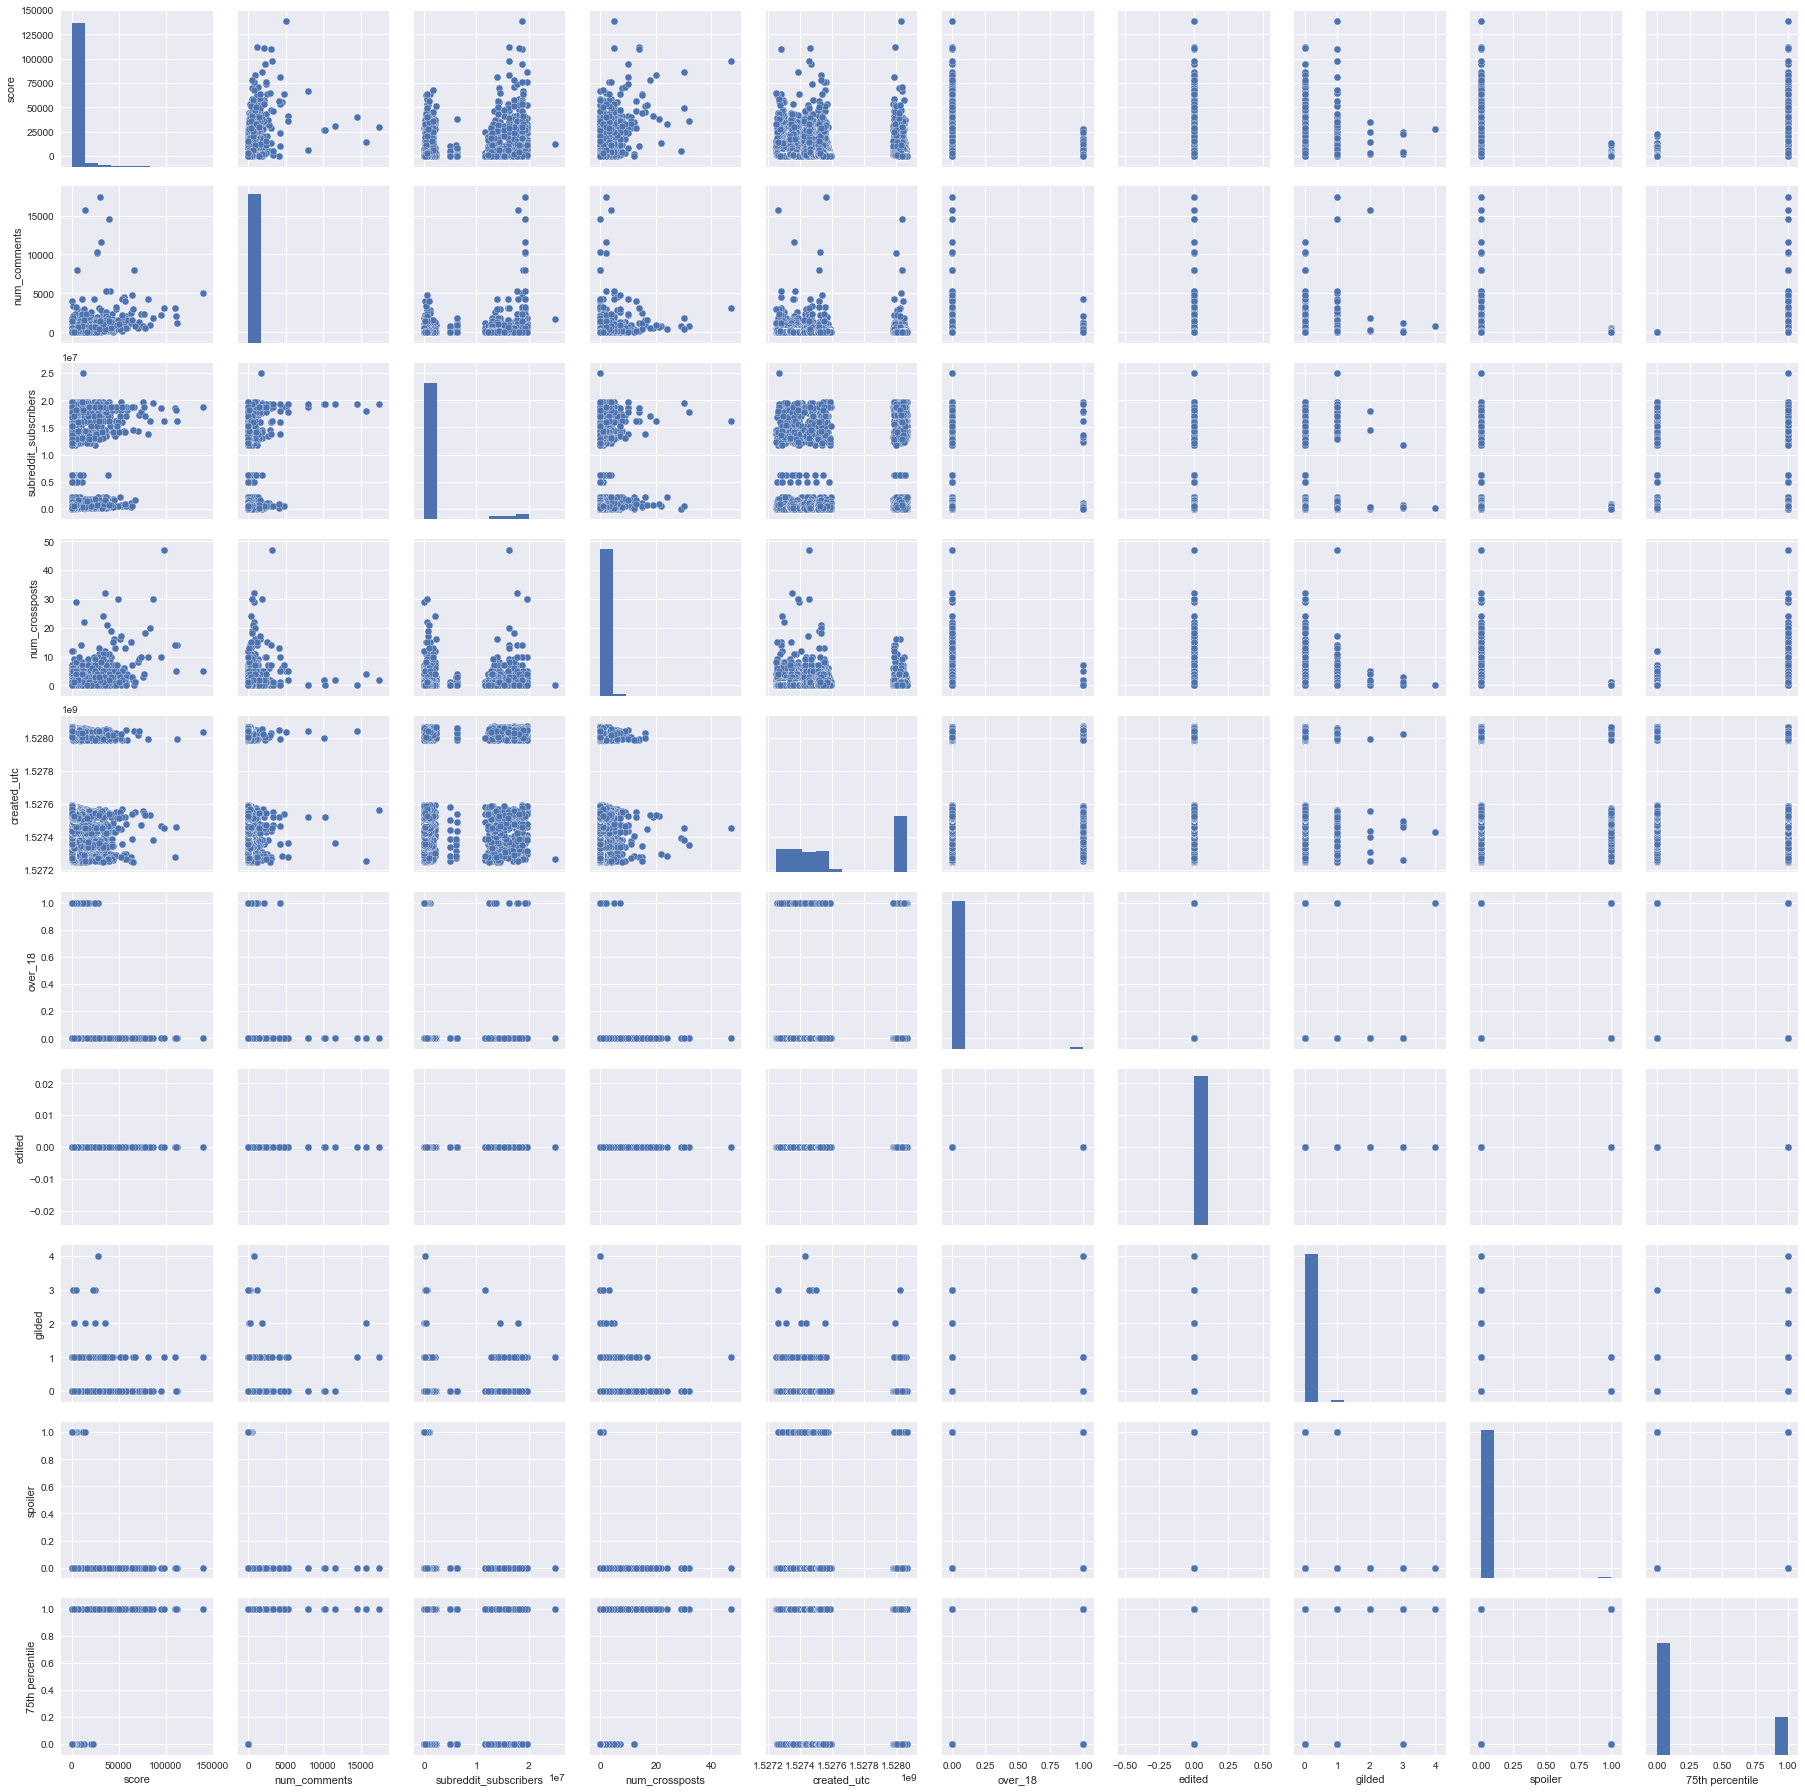

In [11]:
# Not much in the way of correlations for the boolean and numeric data
sns.pairplot(hot_posts);

In [169]:
# The median is 18 comments, but if we're talking about posts gaining traction,
# the 75th percentile is a more reasonable cutoff (and even then, possibly too
# low)
hot_posts['num_comments'].describe()

count    15431.000000
mean        78.871233
std        360.699362
min          0.000000
25%          7.000000
50%         18.000000
75%         51.000000
max      17377.000000
Name: num_comments, dtype: float64

In [9]:
# Create a binary variable for target column
hot_posts['75th percentile'] = (hot_posts['num_comments'] >= 51)

In [117]:
# Almost entirely composed of questions and invitiations to engage
hot_posts.sort_values('num_comments', ascending=False)['title'][:10]

13034    What's your "it's expensive but it's worth it"...
8161     I am Dr. Jordan B Peterson, U of T Professor, ...
2180     What are some of the BEST choices, you've made...
8717     Doctors/nurses of Reddit; What is the most obv...
13476    What did your parents allow you to do that you...
5442     [Serious] When driving at night, what is the s...
14358    What names are often tied to a specific person...
2186     Trudeau: It's 'insulting' that the US consider...
8470     Waiters who grate cheese until customers say “...
6184     What streaming on Twitch fulltime does to your...
Name: title, dtype: object

#### Thought experiment: What is the baseline accuracy for this model?

In [12]:
# Taking the splitting point at the 75th percentile (51 comments), our baseline
# would simply be the percentile itself as it describes the percentage of our
# majority class (somewhat tautalogically)

#### Create a Random Forest model to predict High/Low number of comments using Sklearn. Start by ONLY using the subreddit as a feature. 

In [13]:
X = pd.get_dummies(hot_posts['subreddit']) # Features will be one-hot-encoded
y = hot_posts['75th percentile'] # Binary target variable from earlier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [14]:
# While it may seem to perform relatively well, it is worth considering that
# subreddits with a greater number of subscribers naturally will get more lively
# discussions. It really calls into question the metric that we're judging.
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.8142417368762151

In [15]:
# We can see that our model was slightly overfit as we crossvalidate our data
rf.score(X_test, y_test)

0.7538062844185294

#### Create a few new variables in your dataframe to represent interesting features of a thread title.
- For example, create a feature that represents whether 'cat' is in the title or whether 'funny' is in the title. 
- Then build a new Random Forest with these features. Do they add any value?
- After creating these variables, use count-vectorizer to create features based on the words in the thread titles.
- Build a new random forest model with subreddit and these new features included.

In [37]:
# Using apply and lambda functions, we can efficiently generate new column
# values without ever needing to implement a helper function. Numpy's built in
# where() method beautifully complements python's str.contains() method for
# regex. As for what we will seek in the titles, words that lead into questions
# seem natural given that they are meant to start conversations.

# Regex search for whether 'iama' or 'I am' (case insensitve) appear in the title of a post
hot_posts['iam'] = np.where(hot_posts[['title']].apply(
    lambda x: x.str.contains(r'(?i)iama|I am')).any(1), '1', '0')
# Searching for 'who'
hot_posts['who'] = np.where(hot_posts[['title']].apply(
    lambda x: x.str.contains(r'(?i)who')).any(1), '1', '0')
# Searching for 'what'
hot_posts['what'] = np.where(hot_posts[['title']].apply(
    lambda x: x.str.contains(r'(?i)what')).any(1), '1', '0')
# Searching for 'where'
hot_posts['where'] = np.where(hot_posts[['title']].apply(
    lambda x: x.str.contains(r'(?i)where')).any(1), '1', '0')
# Searching for 'when'
hot_posts['when'] = np.where(hot_posts[['title']].apply(
    lambda x: x.str.contains(r'(?i)when')).any(1), '1', '0')
# Searching for 'why'
hot_posts['why'] = np.where(hot_posts[['title']].apply(
    lambda x: x.str.contains(r'(?i)why')).any(1), '1', '0')
# Searching for 'how'
hot_posts['how'] = np.where(hot_posts[['title']].apply(
    lambda x: x.str.contains(r'(?i)how')).any(1), '1', '0')

In [40]:
# First we'll try with both the subreddit feature and the new ones
X = pd.get_dummies(hot_posts['subreddit'])
pd.concat([X, hot_posts[['iam', 'who', 'what', 'where', 'when', 'why', 'how']]])
y = hot_posts['75th percentile'] # Binary target variable from earlier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2) # Test train split

In [41]:
# Similar results
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.8117303953337653

In [42]:
# Alas, no gain. Perhaps the choice of features was not as beneficial as I had
# hoped.
rf.score(X_test, y_test)

0.7560738581146744

In [43]:
# Now with only the new features
X = hot_posts[['iam', 'who', 'what', 'where', 'when', 'why', 'how']]
y = hot_posts['75th percentile'] # Binary target variable from earlier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2) # Test train split

In [44]:
# Either the model has diminished in quality, or the fit has improved
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.748298768632534

In [45]:
# The model has a good fit, but poor predictive power. It is intersting to see
# how just those few features could result in an equally good model as the
# subreddit featureset, yet could add nothing to the other when used in tandem
rf.score(X_test, y_test)

0.7586653709102689

In [48]:
# We'll eliminate stopwords and allow n-grams up to 2
cvec = CountVectorizer(stop_words='english', ngram_range=(1, 2))

In [49]:
X_counts = cvec.fit_transform(hot_posts['title'])
y = hot_posts['75th percentile']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_counts, y, test_size=.2)

In [63]:
# Very promising, but it must be validated!
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.9566591056383669

#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy of the model, as well as any other metrics you feel are appropriate. 

In [64]:
# Womp womp womp. Outperformed by simpler models.
rf.score(X_test, y_test)

0.7175251052802073

#### Repeat the model-building process with a non-tree-based method.

In [9]:
# Filling the feature space with what might help a model. Would be better to
# also have regularization
X = pd.get_dummies(hot_posts['subreddit'])
pd.concat([X, hot_posts[['score', 'subreddit_subscribers', 'num_crossposts',
                        'gilded']]])
y = hot_posts['75th percentile']

In [70]:
# An untuned logistic regression model, just to get the lay of the land before
# moving on to SVM
logistic = LogisticRegression()
cross_val_score(logistic, X, y, scoring='accuracy', cv=5).mean()

0.7458435243322676

In [10]:
# A gaussian classifier was chosen since the ratio of observations to features
# was reasonably high. It would have been preferable to grid search over the
# hyperparameter values to optimize the fit, but it took more than 30 mintues
# to run this block alone. Time does not permit investingating this further at
# this time unfortunately.
clf = svm.SVC(kernel='rbf', gamma=0.001, C=1)
cross_val_score(clf, X, y, scoring='accuracy', cv=3).mean()

0.7495949690585895

#### Use Count Vectorizer from scikit-learn to create features from the thread titles. 
- Examine using count or binary features in the model
- Re-evaluate your models using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [94]:
# Trying TF-IDF to see if it goes any better
tvec = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))

In [95]:
X_counts = tvec.fit_transform(hot_posts['title'])
y = hot_posts['75th percentile']

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X_counts, y, test_size=.2)

In [12]:
# Likely overfit
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_train, y_train)

0.9415100453661698

In [13]:
# Was very overfit in fact
rf.score(X_test, y_test)

0.7288629737609329

In [17]:
# Seeing if extra trees performs better
et = ExtraTreesClassifier()
s = cross_val_score(et, X_counts, y, cv=3, n_jobs=-1)

In [27]:
# No such luck
print('Extra trees score:', s.mean())
print('Extra trees margin of error:', s.std())

Extra trees score: 0.7334586704139273
Extra trees margin of error: 0.0012290951785648234


In [96]:
# Finding most commonly used words
sum_words = X_counts.sum(axis=0)

In [97]:
# A manual counter built into a loop for each word in a list
words_freq = [(word, sum_words[0, i]) for word, i in tvec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

In [98]:
# To dataframe
wordcount = pd.DataFrame(words_freq, columns=['word', 'frequency'])

In [119]:
# Most popular words in all data
wordcount.head(20)

,word,frequency
0,just,70.519195
1,like,62.617845
2,time,55.844332
3,hmmm,53.453239
4,new,52.566932
5,day,43.505093
6,got,41.763103
7,today,41.071173
8,2meirl4meirl,40.000000
9,irl,39.692245


In [100]:
# Same procedure for the top 100 posts in terms of comments
top_posts = (hot_posts.sort_values('num_comments', ascending=False))[:100]

In [101]:
tvec = TfidfVectorizer(stop_words='english', ngram_range=(1, 3))

In [102]:
X_counts = tvec.fit_transform(top_posts['title'])
y = top_posts['75th percentile']

In [103]:
sum_top_words = X_counts.sum(axis=0)

In [108]:
top_words_freq = [(word, sum_top_words[0, i]) for word, i in tvec.vocabulary_.items()]
top_words_freq = sorted(top_words_freq, key = lambda x: x[1], reverse=True)

In [109]:
topcount = pd.DataFrame(top_words_freq, columns=['word', 'frequency'])

In [118]:
# Interesting to see in relation. More upbeat/emotional stuff
topcount.head(20)

,word,frequency
0,people,1.266937
1,invest,1.265350
2,life,1.260857
3,time,1.109835
4,appraised,1.000000
5,admit,1.000000
6,ve,0.898716
7,nice,0.855702
8,years,0.839896
9,movie,0.836885


# Executive Summary
---
Put your executive summary in a Markdown cell below.

<h3 style="text-align: center;">Viral marketing:</h3>
<h5 style="text-align: center;">The Holy Grail of Brand Exposure and Memorability</h5>

From startups that want it to stay afloat to mega-corporations that crave it to stay on top, the attention of a target audience can be a fickle thing. Despite the immeasurable effort that has gone into formalizing a method to gain traction and ideally go viral, the specifics of the process remain elusive. Instead, the only progress that can be said to have been made exists in the form of general guidelines or at best, data-backed tips and tidbits that can suggest what qualities are common in viral content, yet still can give no guarantee on performance.

As an increasing number of entities seek peoples attention, the result is an increase in content creation and dissemination. Unfortunately there is no way to counteract this inundation of stimuli as the days remain constant in duration and we still have not found a workaround to our bodily needs of sleep and sustenance. Add in the ever-connected nature of a present day American adult with the internet, smart phones, and so on, and we get the end result of a general populace with less and less time available as an individual (as opposed to an integrated cog of society). Marketing is not new; it constantly evolves, but as it does, so do the cognitive defenses of the target audience. Unless a signal really stands out from the bunch, we are keen to filter it out. To understand how to reach someone like this, it is worth considering what it is that such a person seeks in the content they consume.

Approaching it from this angle makes the problem intelligible; some of the elements that users crave are personal connection, authenticity, and acknowledgment.

1) Personal connection: Many of the top posts in the data used 'question words' as discussed above. These invite engagement and make users feel included and involved in the conversation, especially if it is on a controversial matter.

2) Authenticity: The top posts are almost exclusively conversational by nature. Most of the remaining top posts are controversial. Corporate tones tend to be dulcet and neutral, but it is unlikely that a business would be able to the channel a conversational tone without seeming to 'try too hard', forfeiting authenticity for tack. This presents an interesting opportunity to eschew the passive, bland messaging that is a dime-a-dozen and work on a message that makes listeners emotionally charged (one way or another).

3) Acknowledgment: Reddit threads often become a conversation between users, and threads that get the most engagement offer some promise of that level of sustained interaction. It should not be surprising that when someone takes the time to write out a message, it is in the hopes that it will be considered by those who read it. 